In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pymongo
import pickle


%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (20.0, 20.0)
matplotlib.rcParams["font.size"] = 26
matplotlib.rcParams["axes.grid"] = True
matplotlib.rcParams["axes.facecolor"] = (0.97,0.97,0.97)

In [3]:
client = pymongo.MongoClient()
db = client.swatford

In [4]:
gene_uid = pd.read_pickle("../data/SSI/gene_uid.p")

In [5]:
bc_uids = list(pd.read_pickle("../data/SSI/bc_uids.p"))

In [6]:
bc_uids = ["D009389","D018919","D017209","D002453","D057890","D004249","D004260","D013006","D002470","D007107",
    "D007249","D001940","D001941","D018384","D049109","D012739","D015262"]

In [7]:
desc_children = pd.Series({doc["uid"]:db.medline.descs.distinct("uid",{"ancestors":{"$in":doc["tn"]}})
               for doc in db.medline.descs.find({"uid":{"$in":bc_uids}})})
desc_children_count = desc_children.apply(len)

In [8]:
desc_children_count

D001940     2
D001941    17
D002453    28
D002470     0
D004249     8
D004260     4
D007107    69
D007249    23
D009389     2
D012739    39
D013006     1
D015262     0
D017209     3
D018384     1
D018919     0
D049109     4
D057890     0
dtype: int64

In [11]:
pd.DataFrame([desc_name_map[desc_children_count.index],desc_children_count]).T

,0,1
D001940,Breast,2
D001941,Breast Diseases,17
D002453,Cell Cycle,28
D002470,Cell Survival,0
D004249,DNA Damage,8
D004260,DNA Repair,4
D007107,Immune System,69
D007249,Inflammation,23
D009389,"Neovascularization, Pathologic",2
D012739,Gonadal Steroid Hormones,39


In [12]:
# desc_children = pd.Series({doc["uid"]:db.medline.descs.find({"ancestors":{"$in":doc["tn"]}}).count() 
#                for doc in db.medline.descs.find({"uid":{"$in":bc_uids}})})

In [10]:
desc_name_map = pd.Series({doc["uid"]:doc["name"] for doc in db.medline.descs.find()})

In [12]:
bc_results = {}
for tup in desc_children.iteritems():
    bc_results[tup[0]] = set(gene_uid[gene_uid.uid.isin(tup[1] + [tup[0]])].gene_id)
#     for x in tup[1]:
#     bc_results[tup[0]] |= set(gene_uid[gene_uid.uid.isin(tup[1])].gene_id)
#         print(x)
    print(tup[0])
bc_results = pd.Series(bc_results)

D001940
D001941
D002453
D002470
D004249
D004260
D007107
D007249
D009389
D012739
D013006
D015262
D017209
D018384
D018919
D049109
D057890


In [18]:
bc_genes = set(pd.read_pickle("../data/SSI/ssi_gene_list.p"))

In [19]:
data = pd.DataFrame([bc_results.apply(len),bc_results.apply(lambda x: len(set(bc_genes) & set(x) )),
                     desc_children_count,desc_name_map[bc_uids]],
             index=["total genes","ssi genes","number of children","name"]).T


In [20]:
data.set_index("name",inplace=True)

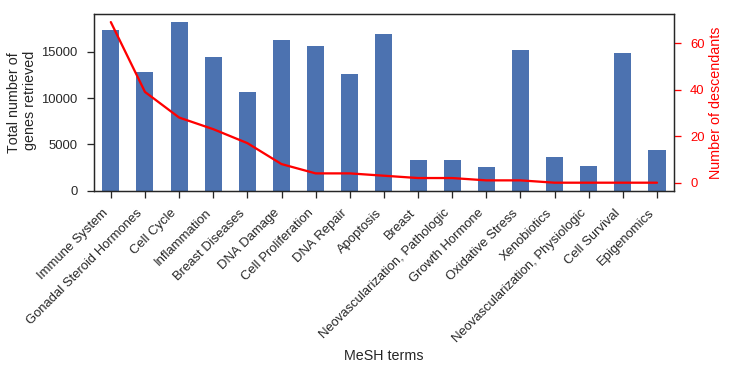

In [51]:
sns.set_context("talk")
sns.set_style("white")

data.sort_values("number of children",ascending=False,inplace=True)

fig = plt.figure()

ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212,sharex=ax1)

ax3 = ax1.twinx()
# ax4 = ax2.twinx()

data["total genes"].plot(ax=ax1,kind="bar")
data["number of children"].plot(ax=ax3,xlim=(-0.5,16.5),color="r")

# data["ssi genes"].plot(ax=ax2,kind="bar")
# data["number of children"].plot(ax=ax4,xlim=(-0.5,16.5),color="r")

ax1.set_ylabel("Total number of\n genes retrieved")
ax1.set_xlabel("MeSH terms")
# ax2.set_xlabel("MeSH Terms")

ax3.tick_params(axis="y",colors="red")
# ax3.set_ylabel("Number of SSI\n Genes Retreived",color="red")
ax3.set_ylabel("Number of descendants",color="red")

# ax4.tick_params(axis="y",colors="red")

# ax4.text(17.6, 120, "Number of Descendants",rotation=90)

for tick in ax1.xaxis.get_ticklabels():
    tick.set_horizontalalignment("right")
    tick.set_rotation(45)
    
ax1.tick_params(axis="both",length=7,top=False)
# ax2.tick_params(axis="both",length=7,top=False)
ax3.tick_params(axis="y",length=7)
# ax4.tick_params(axis="y",length=7)
# fig.suptitle("Retreived Genes per to MeSH Term")
plt.savefig("gene_child_cov.jpeg",dpi=500,transparent=True,bbox_inches="tight")